# Semantic Segmentation of Water using U-Net
# Part 7 - Batch Normalisation


In this part I will explore the effects of adding Batch Normalisation to the model.

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, save_img
import numpy as np
import json, os
from random import shuffle
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import warnings
import re
import time

from unetlib.metrics import BinaryMeanIoU
from unetlib.model import UNet
from unetlib.preprocessing import get_lakes_with_masks, make_dataframes_for_flow, make_data_generators
import unetlib.visualisation as vs

In [2]:
# Imagery directories
nwpu_data_dir = 'nwpu_lake_images/data/'
nwpu_mask_dir = 'nwpu_lake_images/masks/'

Batch Normalisation is commonly used when training deep neural networks. Essentially it performs a normalisation of the outputs of one layer prior to input to the next, reducing the variance and speeding up convergence. Additionally, the normalisation means that optimisation is less sensitive to the effects of higher learning rates.

Here I will explore the use of Batch Normalisation within my U-Net architecture. For a more in-depth explanation refer to: https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338.

## Add BN Layers
I'll redefine my U-Net model by adding `BatchNormalization` layers. There seems to be ongoing discussions in the literature regarding the placement of BN layers before or after activation functions. I'll try both configurations so I have created a new `conv2D_BN` function with a `bn_pos` parameter to specify the BN placement.

In [3]:
# Convenience function for adding BN to a Conv2D layer
def conv2D_BN(x, filters, kernel_size=(3, 3), activation='relu', padding='same',
              bn_pos='after'):
    """Convolution with Batch Normalisation.
    
    Parameters
    ----------
    x: tensorflow.Tensor
        Input tensor.
    filters: int
        Number of output filters in the convolution.
    kernel_size: tuple of int, default=(3,3)
        Height and width of convolutional kernel.
    activation: str, default='relu'
        Activation function to use. See TensorFlow / Keras
        documentation for valid arguments.
    padding: {'same', 'valid'}
        Padding strategy applied to input tensor `x`.
    bn_pos: {'after', 'before'}
        Position of BatchNormalisation layer relative to activation
        function.
    
    Returns
    -------
    tensorflow.Tensor
    """
    if bn_pos.lower() == 'after':
        x = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(x)
        x = tf.keras.layers.BatchNormalization()(x)
    elif bn_pos.lower() == 'before':
        x = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.get(activation)(x)
    else:
        raise ValueError('`bn_pos` must be one of "after", "before".')
    
    return x

# New UNet function including batchnorm
def UNet_BN(input_shape=(256, 256, 3), n_filters=64, n_blocks=4, bn_pos='after',
            model_name='UNet_BN'):
    """Create UNet Model.
    
    Creates a UNet architecture a la
    Olaf Ronneberger et al.
    
    Each block contains a Batch Normalisation
    layer with the placement determined by `bn_pos`.
    
    Parameters
    ----------
    input_shape: tuple of int:
        The dimensions of the input images in the form
        (H,W,C).
    n_filters: int, default=64
        The number of filters to use in the first convolution
        block. Default is 64 as used in Ronneberger et al.
    n_blocks: int, default=4
        The number of blocks implemented on each path. Default
        is 4 as used in Ronneberger et al.
    bn_pos: str, {"after", "before"}
        Position of BatchNormalisation layer relative to activation
        function.
    model_name: str, default='UNet_BN'
        A name to assign to the model.
        
    Returns
    -------
    tensorflow.keras.models.Model:
        The configured U-Net model.
    """
    # Reference to input layer
    in_ = Input(input_shape)
    
    # Copy input layer for operations
    x = in_
    
    # Blocks on each side of the UNet architecture
    blocks = n_blocks
    
    # Keep track of layers for concatenation on the DECODE side
    concat_layers = []
    
    ## ---- ENCODER ----
    # An encoder block consists of CONV2D=>CONV2D=>MAXPOOL
    enc_filters = n_filters
    for block in range(blocks):
        
        # Block of Conv2D & MaxPooling2D
        x = Conv2D(filters=enc_filters, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = conv2D_BN(x, filters=enc_filters, kernel_size=(3, 3), activation='relu', padding='same',
                     bn_pos=bn_pos)
        
        # Append to layer list for concatenation
        concat_layers.append(x)
        
        x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)
        
        # Increase number of filters
        enc_filters *= 2
        
    # Final Conv2D before upsampling
    x = Conv2D(filters=enc_filters, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = conv2D_BN(x, filters=enc_filters, kernel_size=(3, 3), activation='relu', padding='same',
                     bn_pos=bn_pos)
    
    
    ## ---- DECODER ---- ##
    # A decoder block consists of CONV2DTRANS=>CONCAT=>CONV2D=>CONV2D
    dec_filters = enc_filters / 2
    for block in range(blocks):
        
        # Block of Conv2DTranspose, Concatenate & Conv2D
        x = Conv2DTranspose(dec_filters, kernel_size=(2,2), strides=(2, 2), padding='same')(x)
    
        # Concatenate with corresponding layer output from the encoding side of
        # the UNet.    
        concat = concatenate([concat_layers.pop(), x], axis=3)
        
        x = Conv2D(filters=dec_filters, kernel_size=(3, 3), activation='relu', padding='same')(concat)
        x = conv2D_BN(x, filters=dec_filters, kernel_size=(3, 3), activation='relu', padding='same',
                     bn_pos=bn_pos)
    
        dec_filters /= 2
    
    # ---- OUTPUT ----
    # Output a single channel with the probability that the pixel
    # is the positive class e.g. foreground, water etc.
    out_ = Conv2D(1, 1, activation='sigmoid')(x)
    
    model_name = f'{model_name}_f{n_filters}_b{n_blocks}_bn{bn_pos}'
    model = Model(inputs=in_, outputs=out_, name=model_name)
    
    return model

For convenience, I'll wrap the training process in a function that also prepares the training and validation data. This function simply requires a model i.e. the output of `UNet_BN`. I have included some optional parameters with default arguments matching those used previously.

In [12]:
# Wrapper for training process with some hyperparameters
def train_unet(model, batch_size=16, epochs=100, optimiser='RMSProp',
               learning_rate=None, save_as=None):
    """Train U-Net model.
    
    Train `model` and save history and best weights.
    
    Parameters
    ----------
    model: tensorflow.keras.models.Model
        UNet model that will be trained.
    batch_size: int, default=16
        Number of image/mask pairs in each batch of training
        and validation data.
    epochs: int, default=100
        Duration of training i.e. number of passes through the
        full training set.        
    optimiser: str, default='RMSProp'
        Optimisation algorithm. Refer to Keras documentation
        for available optimisers.
    learning_rate: float, optional
        Learning rate for `optimiser`. If None, will use
        `optimiser`'s default learning rate'.
    save_as: str, optional
        Base output path name used for savinng model history
        and weights. Defaults to `model.name`. Note that the
        actual output file names are laundered to include the
        `batch_size` and `epochs` arguments.
        
    Returns
    -------
    str
        Path to model history output file. 
    """
    # Split the test/train data
    (train_img_df, train_msk_df,
     test_img_df, test_msk_df) = make_dataframes_for_flow(nwpu_data_dir,
                                                          nwpu_mask_dir,
                                                          test_split=0.25,
                                                          random_state=42
                                                         )

    # Split the training data into train and validation generators
    # with augmentation applied to the training data only
    aug_dict = {'rotation_range':90,
                'horizontal_flip':True,
                'vertical_flip':True,
                'width_shift_range':0.15,
                'height_shift_range':0.15,
                'zoom_range':0.25
               }

    (train_gen, val_gen,
     train_fps, val_fps) = make_data_generators(train_img_df, train_msk_df,
                                                nwpu_data_dir, nwpu_mask_dir,
                                                val_split=0.3,
                                                batch_size=batch_size,
                                                aug_dict=aug_dict,
                                                aug_seed=42)
    
    
    # Compute steps per epoch
    train_steps = int(np.ceil(len(train_fps) / batch_size))
    val_steps = int(np.ceil(len(val_fps) / batch_size))
    
    # Output paths
    if save_as is None:
        base_name = f'{model.name}_bs{batch_size}e{epochs}'
    else:
        base_name = f'{save_as}_bs{batch_size}e{epochs}'
        
    hist_filepath = base_name + '.history.pickle'
    weights_filepath = base_name + '.weights.h5'
        
    if os.path.dirname(hist_filepath) != '':
        os.makedirs(os.path.dirname(hist_filepath), exist_ok=True)
    if os.path.dirname(weights_filepath) != '':
        os.makedirs(os.path.dirname(weights_filepath), exist_ok=True)

    # Configure optimiser
    if isinstance(optimiser, str):
        optimiser = tf.keras.optimizers.get(optimiser)
        if learning_rate is not None:
            optimiser.lr = learning_rate
            
    # Configure callbacks
    checkpointer = tf.keras.callbacks.ModelCheckpoint(weights_filepath,
                                                      save_best_only=True,
                                                      save_weights_only=True
                                                     )
    callbacks=[checkpointer]
    
    # Compile model  
    model.compile(optimizer=optimiser,
                  loss='binary_crossentropy',
                  metrics=[BinaryMeanIoU(threshold=0.5)]
                 )

    # Train the model and record the time taken
    t1 = time.time()
    history = model.fit(train_gen, epochs=epochs, steps_per_epoch=train_steps,
                        validation_data=val_gen, validation_steps=val_steps,
                        callbacks=callbacks
                       )
    print(f"Model {base_name} training time: {time.time() - t1}")
    
    # Save history to pickle
    with open(hist_filepath, 'wb') as f:
        pickle.dump(history.history, f)
        
    return hist_filepath

## Deep Model

In [4]:
# Train deep model with BN before activation
# model_deepbf = UNet_BN(n_filters=32, bn_pos='before', model_name='deep')
# deepbf_hist_filepath = train_unet(model_deepbf)

# or use pre-trained model
deepbf_hist_filepath = 'model_outputs/deep_f32_b4_bnbefore_bs16e100.history.pickle'

In [5]:
# Train deep model with BN after activation
# model_deepaf = UNet_BN(n_filters=32, bn_pos='after', model_name='deep')
# deepaf_hist_filepath = train_unet(model_deepaf)

# or use pre-trained model
deepaf_hist_filepath = 'model_outputs/deep_f32_b4_bnafter_bs16e100.history.pickle'

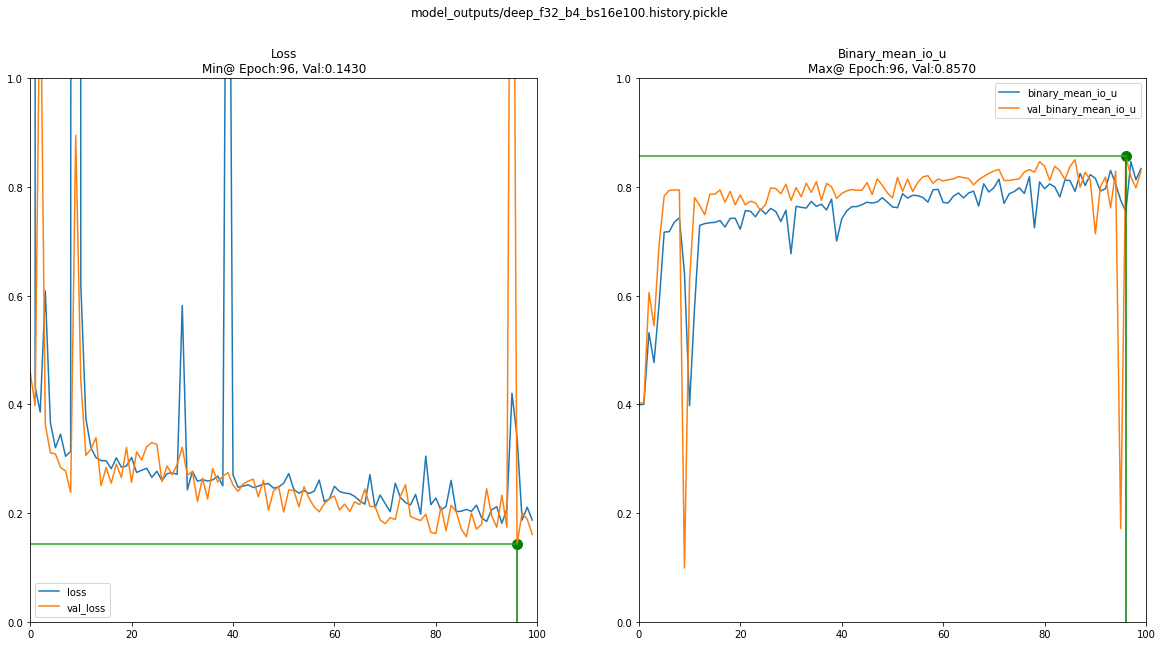

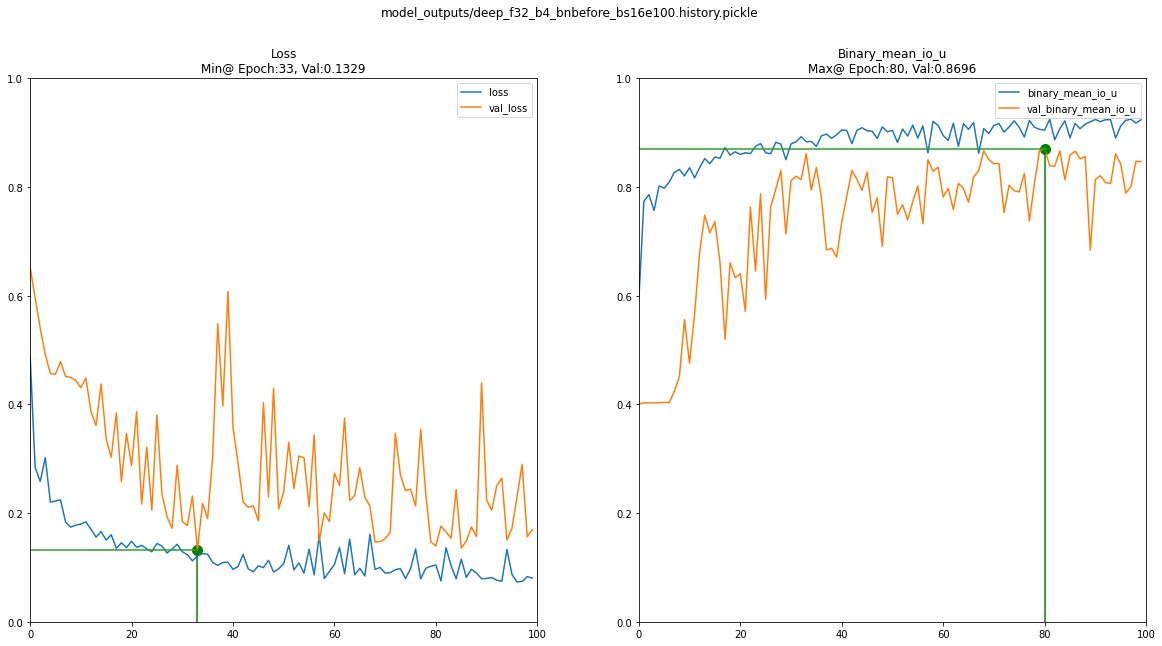

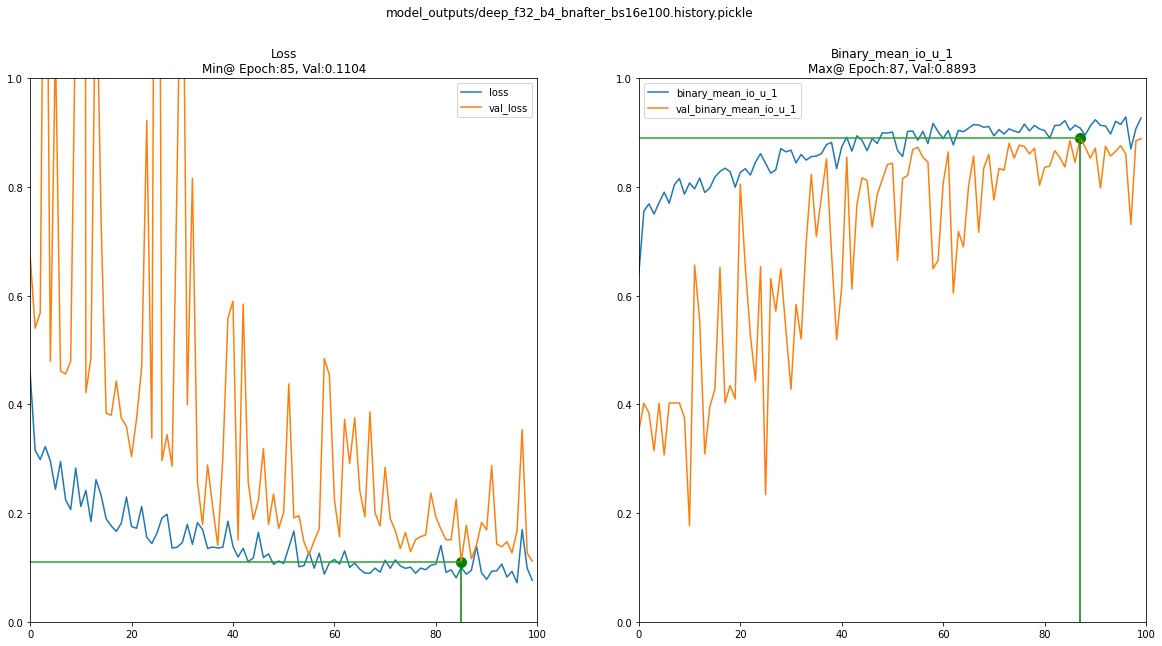

In [6]:
# Review learning curves - include no BN for reference
# Deep / Deep with BN before / BN after
deep_hist_filepath = 'model_outputs/deep_f32_b4_bs16e100.history.pickle'

with open(deep_hist_filepath, 'rb') as f:
    deep_hist = pickle.load(f)
    
with open(deepbf_hist_filepath, 'rb') as f:
    deepbf_hist = pickle.load(f)
    
with open(deepaf_hist_filepath, 'rb') as f:
    deepaf_hist = pickle.load(f)

# Create dataframe of history
deep_hist_df = pd.DataFrame(deep_hist)
deepbf_hist_df = pd.DataFrame(deepbf_hist)
deepaf_hist_df = pd.DataFrame(deepaf_hist)

# Plot history
vs.plot_model_history(deep_hist_df, metrics=['loss', 'binary_mean_io_u'],
                      best=['min', 'max'], title=deep_hist_filepath);

vs.plot_model_history(deepbf_hist_df, metrics=['loss', 'binary_mean_io_u'],
                      best=['min', 'max'], title=deepbf_hist_filepath);

vs.plot_model_history(deepaf_hist_df, metrics=['loss', 'binary_mean_io_u_1'],
                      best=['min', 'max'], title=deepaf_hist_filepath);

In [48]:
columns = ['Filepath', 'Val Loss', 'Val IoU']
deep_results = list()

for fn, df in zip([deep_hist_filepath, deepbf_hist_filepath, deepaf_hist_filepath],
                  [deep_hist_df, deepbf_hist_df, deepaf_hist_df]):
    
    # pattern match for mean iou column as some have suffix numbers
    iou_col_name = df.columns[df.columns.str.contains('val_binary_mean.*', regex=True).argmax()]
    deep_results.append({k:v for k, v in zip(columns, [os.path.basename(fn), df.val_loss.min(),
                                                       df.at[df.val_loss.argmin(), iou_col_name]
                                                      ])}
                       )

deep_results_df = pd.DataFrame(deep_results)
deep_results_df

,Filepath,Val Loss,Val IoU
0,deep_f32_b4_bs16e100.history.pickle,0.143032,0.857046
1,deep_f32_b4_bnbefore_bs16e100.history.pickle,0.132896,0.860775
2,deep_f32_b4_bnafter_bs16e100.history.pickle,0.110429,0.885362


## Wide Model

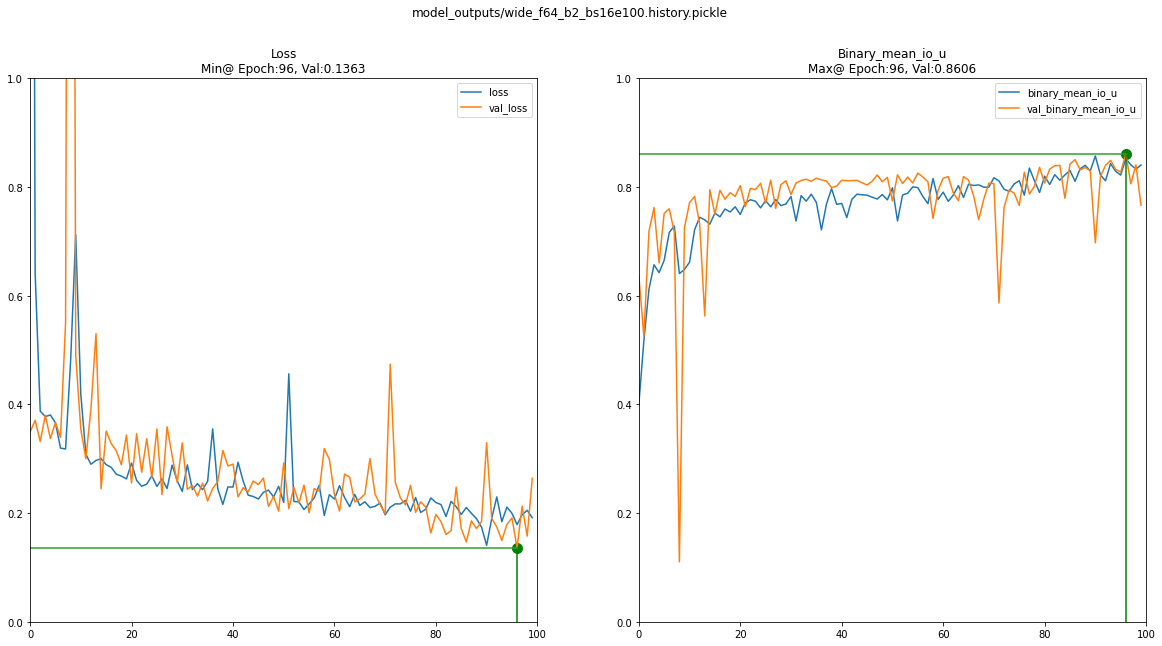

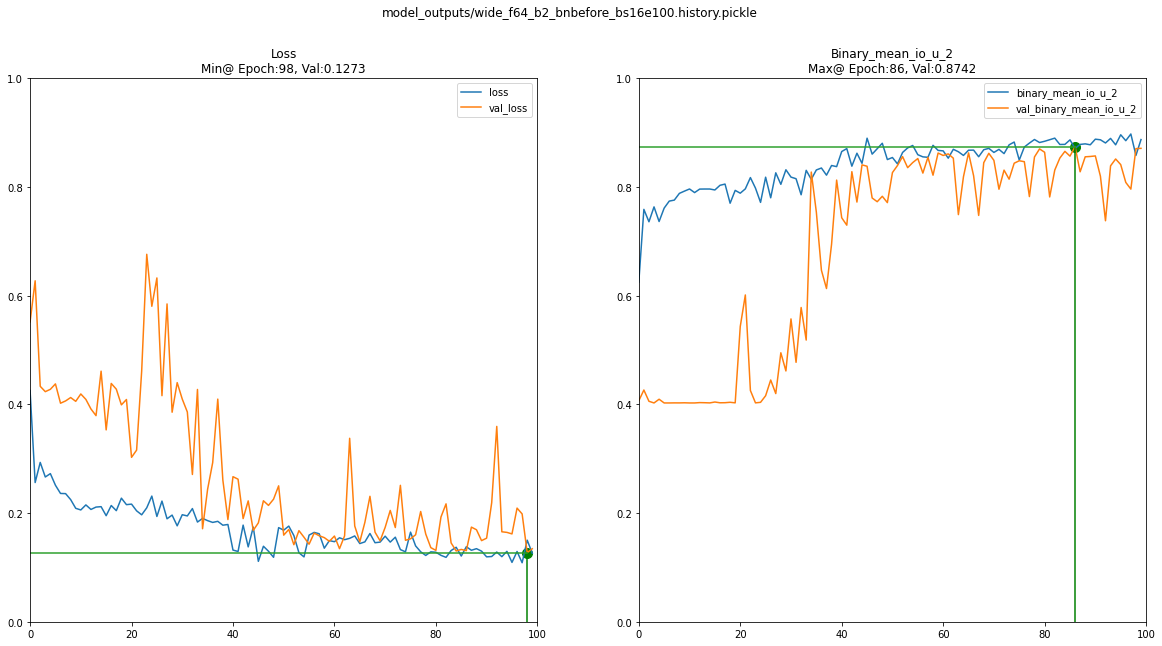

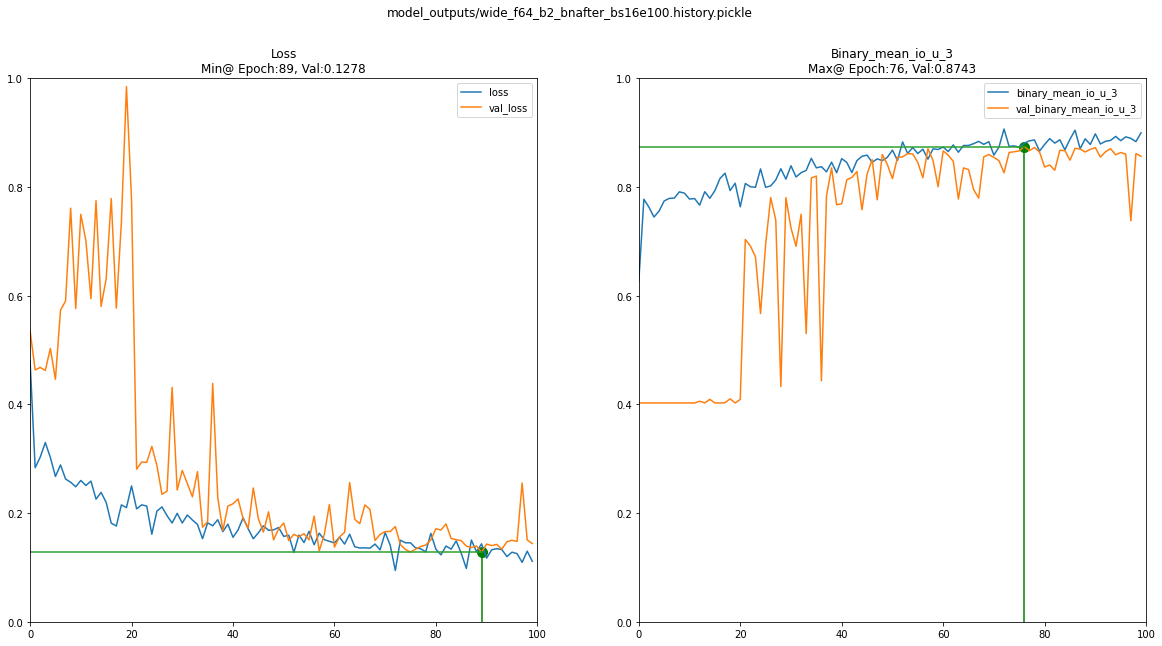

In [42]:
# Wide / Wide with BN before / BN after
wide_hist_filepath = 'model_outputs/wide_f64_b2_bs16e100.history.pickle'
widebf_hist_filepath = 'model_outputs/wide_f64_b2_bnbefore_bs16e100.history.pickle'
wideaf_hist_filepath = 'model_outputs/wide_f64_b2_bnafter_bs16e100.history.pickle'


with open(wide_hist_filepath, 'rb') as f:
    wide_hist = pickle.load(f)
    
with open(widebf_hist_filepath, 'rb') as f:
    widebf_hist = pickle.load(f)
    
with open(wideaf_hist_filepath, 'rb') as f:
    wideaf_hist = pickle.load(f)

# Create dataframe of history
wide_hist_df = pd.DataFrame(wide_hist)
widebf_hist_df = pd.DataFrame(widebf_hist)
wideaf_hist_df = pd.DataFrame(wideaf_hist)

# Plot history
vs.plot_model_history(wide_hist_df, metrics=['loss', 'binary_mean_io_u'],
                      best=['min', 'max'], title=wide_hist_filepath);

vs.plot_model_history(widebf_hist_df, metrics=['loss', 'binary_mean_io_u_2'],
                      best=['min', 'max'], title=widebf_hist_filepath);

vs.plot_model_history(wideaf_hist_df, metrics=['loss', 'binary_mean_io_u_3'],
                      best=['min', 'max'], title=wideaf_hist_filepath);

In [49]:
columns = ['Filepath', 'Val Loss', 'Val IoU']
wide_results = list()

for fn, df in zip([wide_hist_filepath, widebf_hist_filepath, wideaf_hist_filepath],
                  [wide_hist_df, widebf_hist_df, wideaf_hist_df]):
    
    # pattern match for mean iou column as some have suffix numbers
    iou_col_name = df.columns[df.columns.str.contains('val_binary_mean.*', regex=True).argmax()]
    wide_results.append({k:v for k, v in zip(columns, [os.path.basename(fn), df.val_loss.min(),
                                                       df.at[df.val_loss.argmin(), iou_col_name]
                                                      ])}
                       )

wide_results_df = pd.DataFrame(wide_results)
wide_results_df

,Filepath,Val Loss,Val IoU
0,wide_f64_b2_bs16e100.history.pickle,0.136287,0.860616
1,wide_f64_b2_bnbefore_bs16e100.history.pickle,0.127331,0.870438
2,wide_f64_b2_bnafter_bs16e100.history.pickle,0.127804,0.869118


## Deep & Wide Model

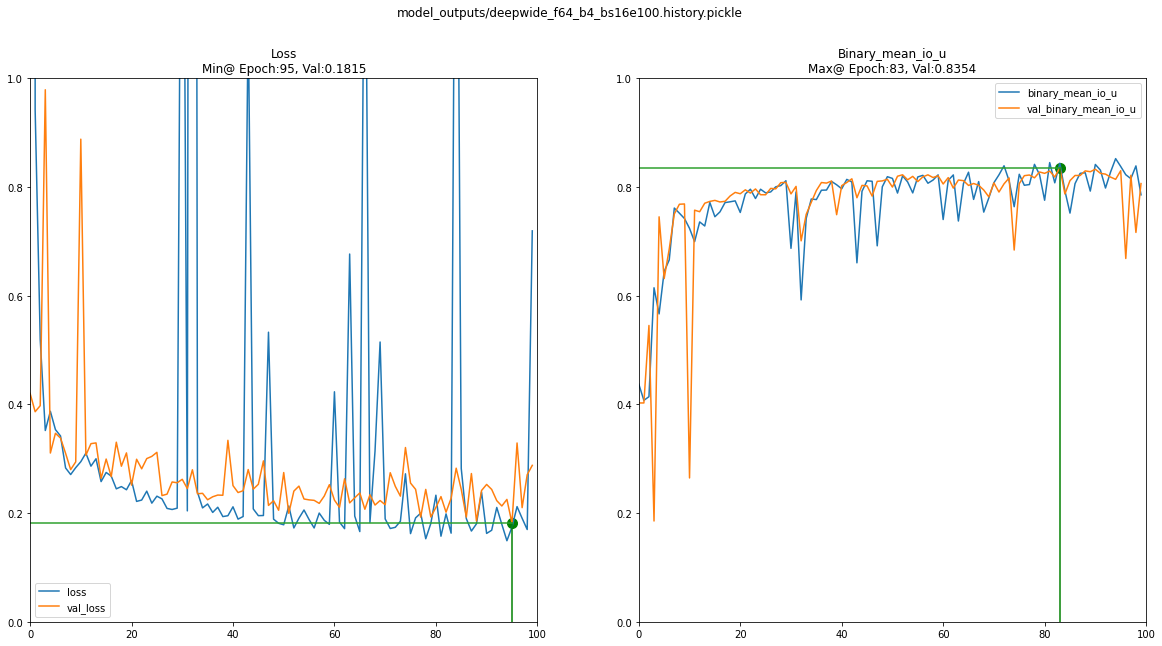

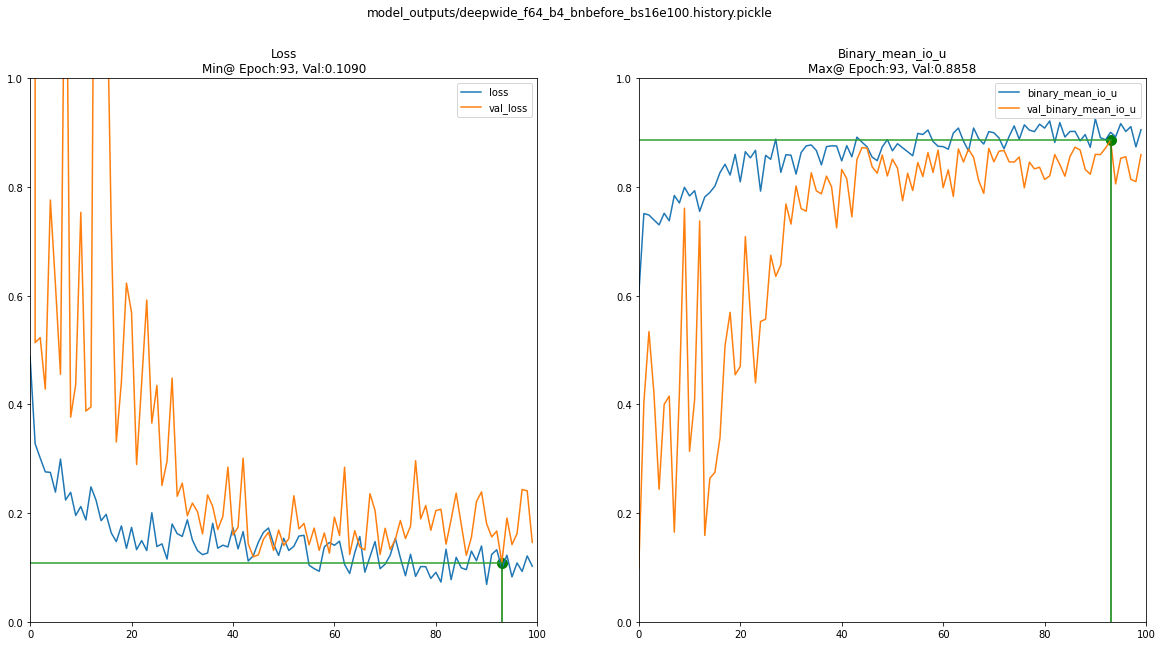

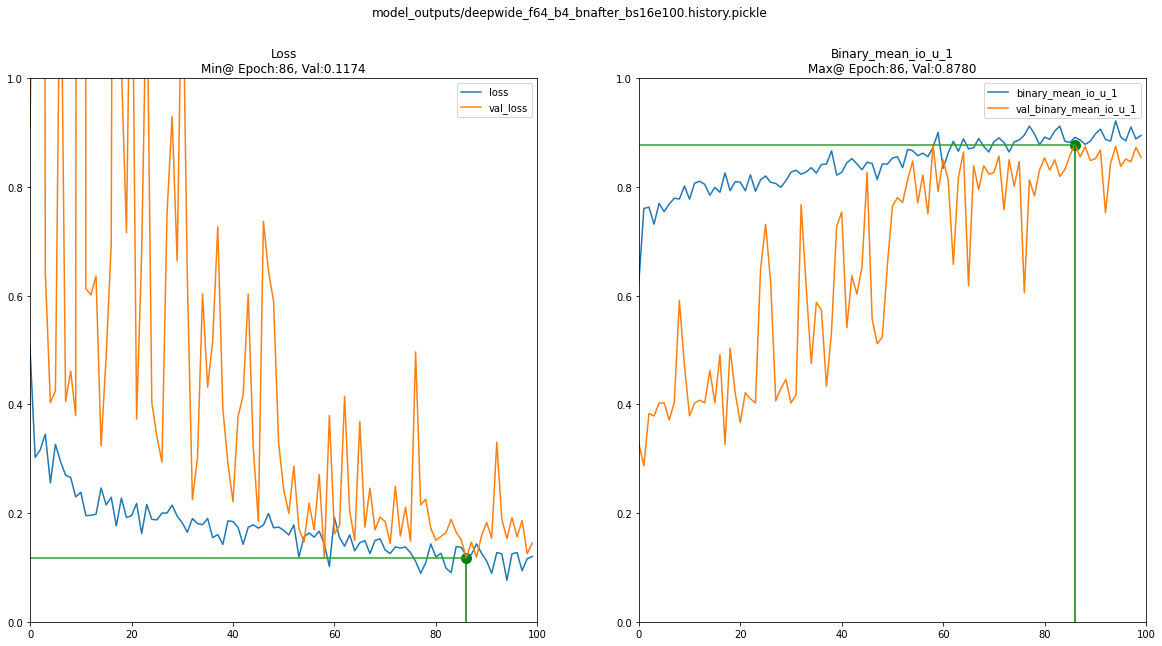

In [45]:
# Deepwide / Deepwide with BN before / BN after
deepwide_hist_filepath = 'model_outputs/deepwide_f64_b4_bs16e100.history.pickle'
deepwidebf_hist_filepath = 'model_outputs/deepwide_f64_b4_bnbefore_bs16e100.history.pickle'
deepwideaf_hist_filepath = 'model_outputs/deepwide_f64_b4_bnafter_bs16e100.history.pickle'


with open(deepwide_hist_filepath, 'rb') as f:
    deepwide_hist = pickle.load(f)
    
with open(deepwidebf_hist_filepath, 'rb') as f:
    deepwidebf_hist = pickle.load(f)
    
with open(deepwideaf_hist_filepath, 'rb') as f:
    deepwideaf_hist = pickle.load(f)

# Create dataframe of history
deepwide_hist_df = pd.DataFrame(deepwide_hist)
deepwidebf_hist_df = pd.DataFrame(deepwidebf_hist)
deepwideaf_hist_df = pd.DataFrame(deepwideaf_hist)

# Plot history
vs.plot_model_history(deepwide_hist_df, metrics=['loss', 'binary_mean_io_u'],
                      best=['min', 'max'], title=deepwide_hist_filepath);

vs.plot_model_history(deepwidebf_hist_df, metrics=['loss', 'binary_mean_io_u'],
                      best=['min', 'max'], title=deepwidebf_hist_filepath);

vs.plot_model_history(deepwideaf_hist_df, metrics=['loss', 'binary_mean_io_u_1'],
                      best=['min', 'max'], title=deepwideaf_hist_filepath);

In [50]:
columns = ['Filepath', 'Val Loss', 'Val IoU']
deepwide_results = list()

for fn, df in zip([deepwide_hist_filepath, deepwidebf_hist_filepath, deepwideaf_hist_filepath],
                  [deepwide_hist_df, deepwidebf_hist_df, deepwideaf_hist_df]):
    
    # pattern match for mean iou column as some have suffix numbers
    iou_col_name = df.columns[df.columns.str.contains('val_binary_mean.*', regex=True).argmax()]
    deepwide_results.append({k:v for k, v in zip(columns, [os.path.basename(fn), df.val_loss.min(),
                                                       df.at[df.val_loss.argmin(), iou_col_name]
                                                      ])}
                       )

deepwide_results_df = pd.DataFrame(deepwide_results)
deepwide_results_df

,Filepath,Val Loss,Val IoU
0,deepwide_f64_b4_bs16e100.history.pickle,0.181531,0.829805
1,deepwide_f64_b4_bnbefore_bs16e100.history.pickle,0.108977,0.885761
2,deepwide_f64_b4_bnafter_bs16e100.history.pickle,0.117353,0.878030


## Results

In [52]:
pd.concat([deep_results_df, wide_results_df, deepwide_results_df], ignore_index=True)

,Filepath,Val Loss,Val IoU
0,deep_f32_b4_bs16e100.history.pickle,0.143032,0.857046
1,deep_f32_b4_bnbefore_bs16e100.history.pickle,0.132896,0.860775
2,deep_f32_b4_bnafter_bs16e100.history.pickle,0.110429,0.885362
3,wide_f64_b2_bs16e100.history.pickle,0.136287,0.860616
4,wide_f64_b2_bnbefore_bs16e100.history.pickle,0.127331,0.870438
5,wide_f64_b2_bnafter_bs16e100.history.pickle,0.127804,0.869118
6,deepwide_f64_b4_bs16e100.history.pickle,0.181531,0.829805
7,deepwide_f64_b4_bnbefore_bs16e100.history.pickle,0.108977,0.885761
8,deepwide_f64_b4_bnafter_bs16e100.history.pickle,0.117353,0.878030


Conclusion.....progress with best val_loss